In [28]:
from langgraph.graph import StateGraph, END, START
from pymongo import MongoClient
import os
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display
from datetime import datetime
import psycopg2
from psycopg2 import sql
from langchain_core.messages import SystemMessage, HumanMessage

In [ ]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")

db = client["local"]

networks_collection = db["networks4"]

network_data = [
    {
        "location": "Mumbai",
        "routers": {
            "Router 1": {"status": "working", "last_checked": "2024-10-10T10:00:00Z"},
            "Router 2": {"status": "not_working", "last_checked": "2024-10-10T09:40:00Z"}
        },
        "switches": {
            "Switch 1": {"status": "not_working", "last_checked": "2024-10-10T10:05:00Z"},
            "Switch 2": {}
        },
        "repeaters": {},
        "access_points": {}
    },
    {
        "location": "Pune",
        "routers": {
            "Router 1": {"status": "working", "last_checked": "2024-10-10T10:00:00Z"},
            "Router 2": {}
        },
        "switches": {},
        "repeaters": {},
        "access_points": {}
    },{
        "location": "Aundh",
        "routers": {
            "Router 1": {"status": "working", "last_checked": "2024-10-10T10:00:00Z"},
            "Router 2": {"status": "working", "last_checked": "2024-10-10T09:40:00Z"}
        },
        "switches": {
            "Switch 1": {"status": "working", "last_checked": "2024-10-10T10:05:00Z"},
            "Switch 2": {}
        },
        "repeaters": {},
        "access_points": {}
    },
    {
        "location": "Hinjewadi",
        "routers": {
            "Router 1": {"status": "not_working", "last_checked": "2024-10-10T10:00:00Z"},
            "Router 2": {}
        },
        "switches": {},
        "repeaters": {},
        "access_points": {}
    }

]

networks_collection.insert_many(network_data)
print("Inserted documents:", list(networks_collection.find()))


In [ ]:
conn = psycopg2.connect(neondb_api)
cursor = conn.cursor()
cursor.execute("""
    CREATE TABLE IF NOT EXISTS tickets (
        ticket_id SERIAL PRIMARY KEY,
        customer_id VARCHAR(255),
        issue_type TEXT,
        location VARCHAR(255),
        status VARCHAR(50),
        created_at TIMESTAMP,
        updated_at TIMESTAMP
    );
""")
conn.commit()


In [29]:
# PostgreSQL Connection
conn = psycopg2.connect(neondb_api)
cursor = conn.cursor()

# MongoDB Connection
client = MongoClient("mongodb://localhost:27017/")
db = client["local"]
networks_collection = db["networks4"]

# LLM Setup
api_key = os.getenv("GROQ_API_KEY", groq_api_key)
llm = ChatGroq(groq_api_key=api_key, model_name="Gemma2-9b-It")

In [30]:
class ChatState(TypedDict):
    query: list
    response: str
    ticket_id: str  
    location: str  
    network_status: str  


In [31]:
# Query Network Database
def networkdata_fetcher(state: ChatState) -> ChatState:
    print(f"Searching in the database")
    queries = state['query']
    results = []
    state["location"] = ""
    state["network_status"] = "unknown"

    if not queries:
        results.append("No query provided.")
    else:
        for query in queries:
            query_words = query.lower().strip().split()
            existing_locations = networks_collection.distinct("location")
            matched_queries = [word for word in query_words if word.capitalize() in existing_locations]

            if not matched_queries:
                results.append(f"No data found for: {query}")
                continue

            regex_pattern = "|".join(matched_queries)
            matched_locations = networks_collection.find({"location": {"$regex": f"^{regex_pattern}$", "$options": "i"}})

            found = False
            for result in matched_locations:
                found = True
                state["location"] = result['location']  
                network_status = result.get("status", "unknown")  
                state["network_status"] = network_status.lower()
                results.append(f"Network details for {result['location']}:\n{result}")

            if not found:
                results.append(f"No data found for: {query}")

    state["response"] = "\n".join(results)
    return state



In [32]:
def network_expert(state: ChatState) -> ChatState:
    print(f"analysing data given by the datafetcher")
    message = f"User Query: {', '.join(state['query'])}\n\n"
    message += f"Network Database Results: {state['response']}\n\n"
    message += "Determine whether the network is working or not based on the data provided."

    messages = [
        SystemMessage(content="check each and every detail if any single thing is not_working then just return not_working, if everything is working then only return working"),
        HumanMessage(content=message)
    ]
    
    try:
        ai_response = llm.invoke(messages)
        response_text = ai_response.content.lower()

        if "not working" in response_text or "issue detected" in response_text:
            state["network_status"] = "not working"
            state = ticketing_expert(state)
        else:
            state["network_status"] = "working"

    except Exception as e:
        state['response'] = f"Error analyzing network status: {str(e)}"
        state["network_status"] = "unknown"

    return state


def ticketing_expert(state: ChatState) -> ChatState:
    print(f"Checking or Creating Ticket")
    queries = state['query']
    if not queries:
        state["response"] = "No issue details provided."
        return state

    issue_type = " ".join(queries)
    location = state.get("location", "")

    if not location:
        state["response"] = "Could not identify a valid location from the query."
        return state

    customer_id = "User-1223456543"  
    current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    cursor.execute(
        sql.SQL("SELECT ticket_id, status FROM tickets WHERE customer_id = %s AND issue_type = %s AND location = %s"),
        [customer_id, issue_type, location]
    )

    existing_ticket = cursor.fetchone()

    if existing_ticket:
        ticket_id, status = existing_ticket
        cursor.execute(
            sql.SQL("UPDATE tickets SET updated_at = %s WHERE ticket_id = %s"),
            [current_datetime, ticket_id]
        )
        conn.commit()
        state["ticket_id"] = ticket_id
        state["response"] = f"Existing Ticket ID: {ticket_id} - Status: {status} - Updated At: {current_datetime}"
    else:
        cursor.execute(
            sql.SQL("INSERT INTO tickets (customer_id, issue_type, location, status, created_at) VALUES (%s, %s, %s, %s, %s) RETURNING ticket_id"),
            [customer_id, issue_type, location, "Open", current_datetime]
        )
        ticket_id = cursor.fetchone()[0]
        conn.commit()
        state["ticket_id"] = ticket_id
        state["response"] = f"New Ticket Created - ID: {ticket_id} - Status: Open - Created At: {current_datetime}"

    return state

In [33]:
def customer_support_agent(state: ChatState) -> ChatState:
    print(f"💬 Calling LLM for final response: {state['query']}")

    message = f"User Query: {', '.join(state['query'])}\n\n"
    message += f"Network Database Results: {state['response']}\n\n"
    message += f"Ticket Info: Ticket ID - {state.get('ticket_id', 'No Ticket')}\n\n"

    messages = [
        SystemMessage(content="Provide a response based on network issues and ticket status."),
        HumanMessage(content=message)
    ]


    try:
        ai_response = llm.invoke(messages)
        formatted_response =ai_response.content.replace(". ", ".\n")
        state['response'] = formatted_response
    except Exception as e:
        state['response'] = f"Error calling LLM: {str(e)}"
    
    return state

In [34]:
workflow = StateGraph(ChatState)

workflow.add_node("networkdata_fetcher", networkdata_fetcher)
workflow.add_node("network_expert", network_expert)
workflow.add_node("ticketing_expert", ticketing_expert)
workflow.add_node("customer_support_agent", customer_support_agent)

workflow.add_edge(START, "networkdata_fetcher")
workflow.add_edge("networkdata_fetcher", "network_expert")

def routing_logic(state: ChatState):
    if "not_working" in state["response"].lower() or "issue detected" in state["response"].lower():
        return "ticketing_expert"
    return "customer_support_agent"

workflow.add_conditional_edges("network_expert", routing_logic, {"customer_support_agent": "customer_support_agent", "ticketing_expert": "ticketing_expert"})
workflow.add_edge("ticketing_expert", "customer_support_agent")
workflow.add_edge("customer_support_agent", END)

app = workflow.compile()

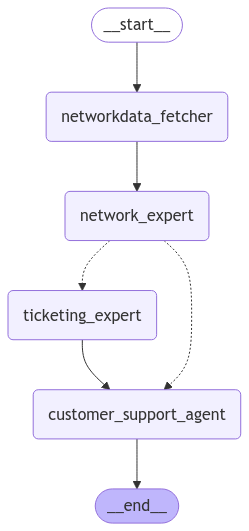

In [35]:
display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))


In [36]:
response = app.stream({"query": ["My network in Hinjewadi is not working, is there any issue"]})

for event in response:
    if "customer_support_agent" in event:
        final_response = event["customer_support_agent"].get("response", "No response available.")
        print("\n" + final_response.replace(". ", ".\n")) 


Searching in the database
analysing data given by the datafetcher
Checking or Creating Ticket
💬 Calling LLM for final response: ['My network in Hinjewadi is not working, is there any issue']

Hi there! 

We're aware of network issues in Hinjewadi.
There's an existing ticket (ID: 11) for this, which is currently open and being investigated.
It was last updated on February 5th at 3:07 AM.


We're working hard to resolve the issue as quickly as possible.
I'll let you know as soon as we have an update.
 

Thanks for your patience! 


